<a href="https://colab.research.google.com/github/animeshjaincambridge/FinanceData/blob/main/LSTM_Natural_gas_price_prediction_AJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv("Henry_Hub_Natural_Gas_Spot_Price.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6609 entries, 0 to 6608
Data columns (total 2 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Day                                                       6609 non-null   object 
 1   Henry Hub Natural Gas Spot Price Dollars per Million Btu  6608 non-null   float64
dtypes: float64(1), object(1)
memory usage: 103.4+ KB


In [3]:
data['Day'] = pd.to_datetime(data['Day'])
data.head()

,Day,Henry Hub Natural Gas Spot Price Dollars per Million Btu
0,2023-04-25,2.21
1,2023-04-24,2.19
2,2023-04-21,2.20
3,2023-04-20,2.19
4,2023-04-19,2.20


In [4]:
data.tail()

,Day,Henry Hub Natural Gas Spot Price Dollars per Million Btu
6604,1997-01-13,4.00
6605,1997-01-10,3.92
6606,1997-01-09,3.61
6607,1997-01-08,3.80
6608,1997-01-07,3.82


In [5]:
# Renaming columns
data = data.rename({'Day': 'date', 'Henry Hub Natural Gas Spot Price Dollars per Million Btu': 'gas_price'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [6]:
data.head(3)

,gas_price
date,
2023-04-25,2.21
2023-04-24,2.19
2023-04-21,2.20


### **EDA**

In [7]:
print(data.isnull().sum())

gas_price    1
dtype: int64


In [8]:
# There is one missing value in the data, we fill it with previous day's price.

data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


In [9]:
fig = px.line(data, title = 'Natural Gas Spot Prices', template = 'plotly_dark')
fig.show()

In [10]:
fig = px.histogram(data, x = "gas_price", template = 'plotly_dark')
fig.show()

In [11]:
data = data.sort_values(by = 'date')

train = data['1997-01-07': '2021-01-06'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2021-01-07': '2023-04-19'] # 7 Jan 2021  to 19 Apr 2023 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  6033
Length of Test Data:  572


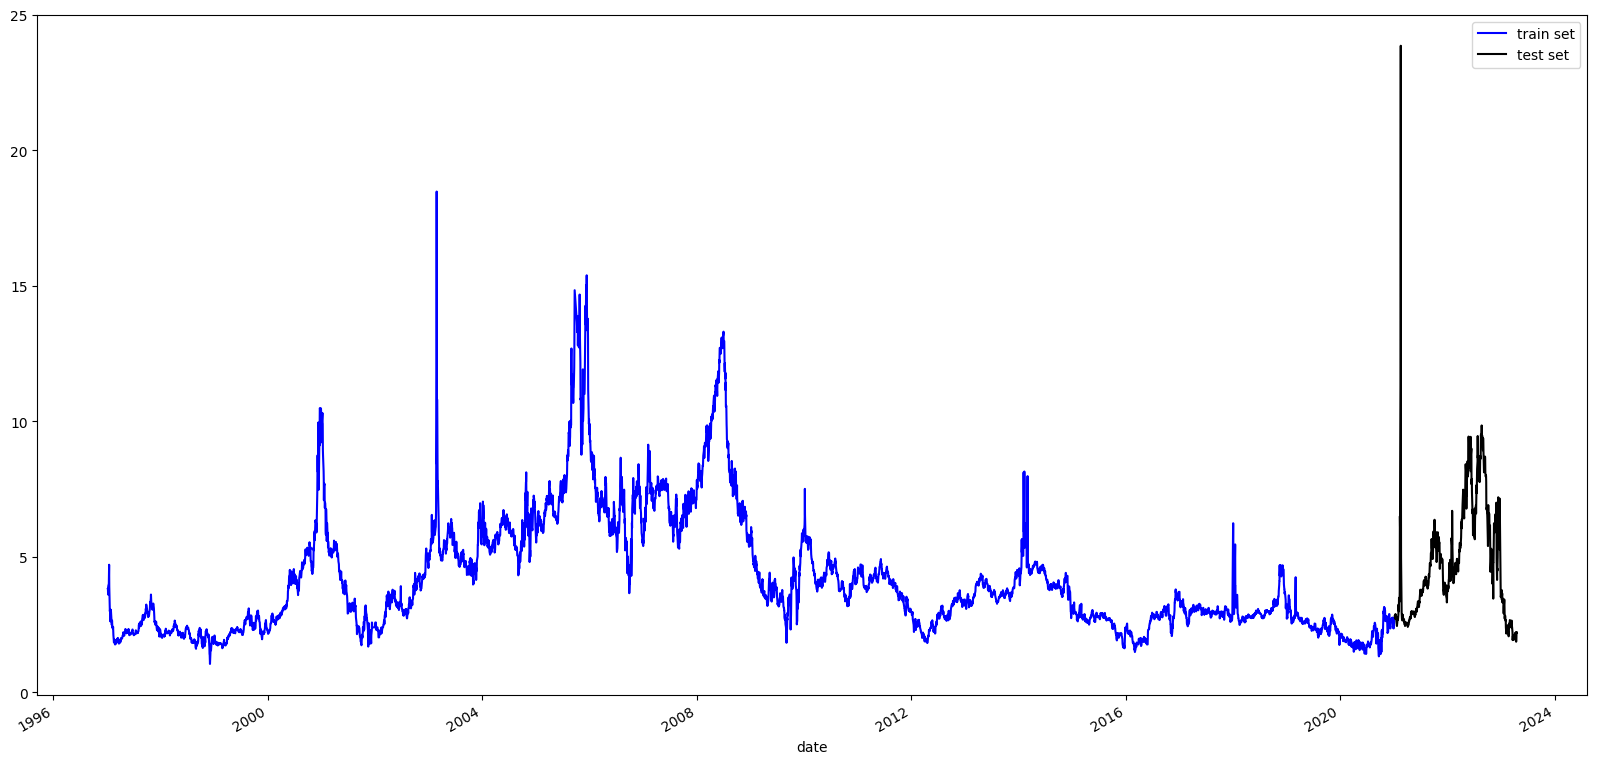

In [12]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

In [13]:
slot = 15

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(6018, 15, 1) (6018,)


In [14]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 100, 
                         batch_size = 64, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

Epoch 1/100
95/95 [==============================] - 29s 105ms/step - loss: 3.3964
Epoch 2/100
95/95 [==============================] - 8s 87ms/step - loss: 3.5734
Epoch 3/100
95/95 [==============================] - 4s 43ms/step - loss: 3.5139
Epoch 4/100
95/95 [==============================] - 4s 42ms/step - loss: 3.4287
Epoch 5/100
95/95 [==============================] - 5s 56ms/step - loss: 3.1009
Epoch 6/100
95/95 [==============================] - 4s 43ms/step - loss: 2.3889
Epoch 7/100
95/95 [==============================] - 4s 43ms/step - loss: 1.8866
Epoch 8/100
95/95 [==============================] - 5s 55ms/step - loss: 1.3047
Epoch 9/100
95/95 [==============================] - 4s 43ms/step - loss: 0.8895
Epoch 10/100
95/95 [==============================] - 4s 47ms/step - loss: 0.6549
Epoch 11/100
95/95 [==============================] - 5s 52ms/step - loss: 0.5293
Epoch 12/100
95/95 [==============================] - 4s 42ms/step - loss: 0.4564
Epoch 13/100
95/95 [===

In [16]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'gp_pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], 1)

189/189 [==============================] - 3s 11ms/step


In [17]:
train_compare.head(3)


,gas_price,gp_pred
date,,
1997-01-28,3.05,2.796810
1997-01-29,2.91,2.854501
1997-01-30,2.86,2.862930


In [18]:
train_compare.tail(3)

,gas_price,gp_pred
date,,
2021-01-04,2.60,2.394964
2021-01-05,2.77,2.412424
2021-01-06,2.76,2.504744


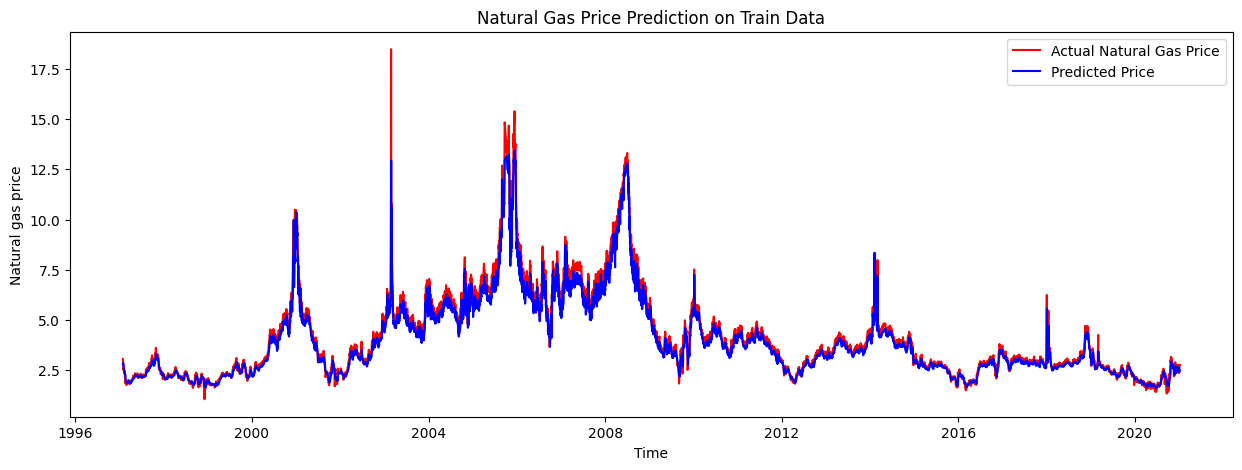

In [19]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [20]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

18/18 [==============================] - 0s 13ms/step


In [21]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

In [22]:
test_compare.head(3)

,gas_price,gp_pred
date,,
2021-01-07,2.81,2.595871
2021-01-08,2.77,2.663701
2021-01-11,2.71,2.685958


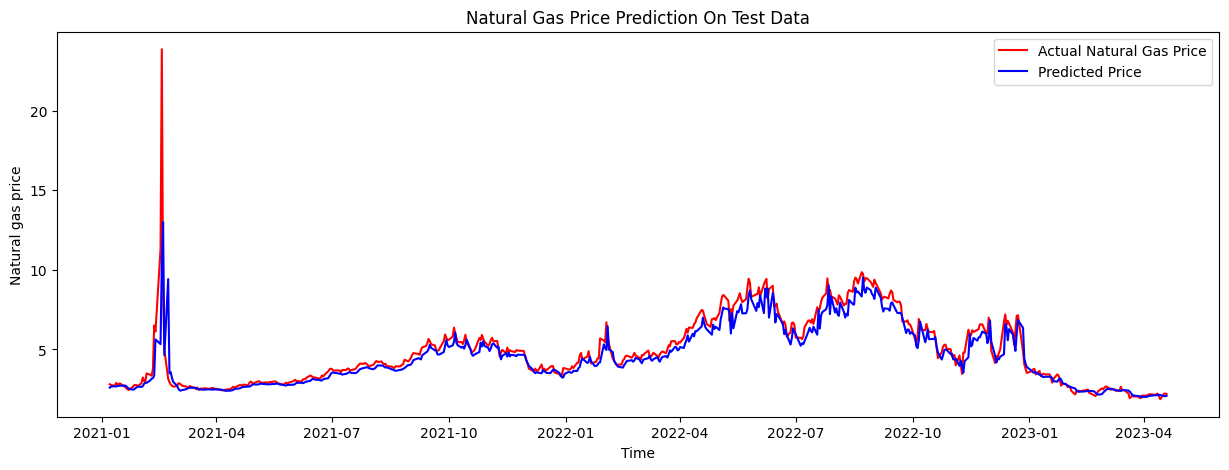

In [23]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [24]:
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['gas_price'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.1560567092357758
R Square: 0.9673936747166403

Test Data:
MSE: 0.739490441516378
R Square: 0.8436398931864251


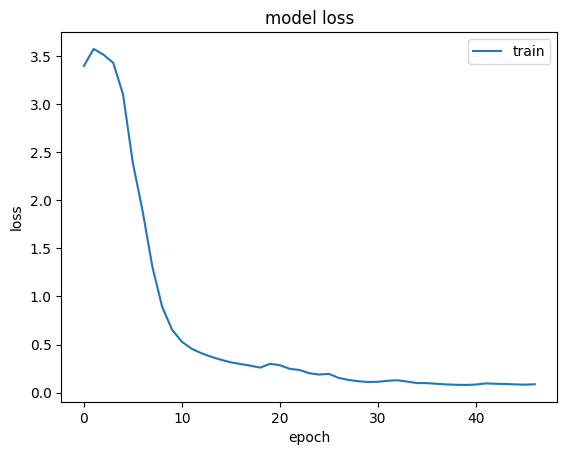

In [25]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [26]:
forecast = pd.DataFrame({'date': pd.date_range(start = '2023-04-19', end = '2023-05-20')})  

inputs = test[len(test) - slot: ].values

for i in range(slot, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-slot:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

1/1 [==============================] - 0s 25ms/step


In [27]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "gp_pred", title = 'Natural Gas Price Forecasting', template = 'plotly_dark')
fig.show()

In [28]:
forecast

,date,gp_pred
0,2023-04-19,1.940000
1,2023-04-20,1.950000
2,2023-04-21,2.100000
3,2023-04-22,2.090000
4,2023-04-23,2.130000
5,2023-04-24,2.170000
6,2023-04-25,2.180000
7,2023-04-26,2.150000
8,2023-04-27,2.190000
9,2023-04-28,2.220000
